### K-Means Clustering
- To undergo K-means clustering, we must first convert the captions to word embeddings
- UMAP is used to reduce dimensionality to the data to allow for better clustering
- Clustering with a fixed cluster size can be achieved with scikit k-means
- Clustering with a non fixed cluster size can be achieved with HDBScan

In [12]:
#required imports
import pandas as pd
import numpy as np

import string
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import KMeans

import umap
import hdbscan

In [22]:
import pandas as pd
import numpy as np

import string
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#### Preparing the data

In [9]:
#import data
blip_train = pd.read_csv("../../input/Landscape/Train/Labels/Blip_Label.csv", index_col=0)
blip_test = pd.read_csv("../../input/Landscape/Test/Labels/Blip_Label.csv", index_col=0)
blip_val = pd.read_csv("../../input/Landscape/Validation/Labels/Blip_Label.csv", index_col=0)

kosmos_train = pd.read_csv("../../input/Landscape/Train/Labels/Kosmos_Label.csv", index_col=0)
kosmos_test = pd.read_csv("../../input/Landscape/Test/Labels/Kosmos_Label.csv", index_col=0)
kosmos_val = pd.read_csv("../../input/Landscape/Validation/Labels/Kosmos_Label.csv", index_col=0)

flickr30k = pd.read_csv("../../input/Flickr30k/flickr30k_classified.csv", index_col=0)

In [10]:
#creating dataframe of all the captions
blip = pd.concat([blip_train, blip_test, blip_val])
kosmos = pd.concat([kosmos_train, kosmos_test, kosmos_val])

In [11]:
blip

,image_filename,image_caption,image_class
0,image_00001.jpg,a beach with sand dunes and blue sky,Coast
1,image_00002.jpg,a tropical island with white sand and palm trees,Coast
2,image_00003.jpg,four people sit on the beach with umbrellas an...,Coast
3,image_00004.jpg,the beautiful beaches of sicily,Coast
4,image_00005.jpg,the beach is a beautiful place to relax and en...,Coast
...,...,...,...
1495,image_01496.jpg,a person climbing inside an ice cave,Mountain
1496,image_01497.jpg,a suspension bridge over a river in the mountains,Mountain
1497,image_01498.jpg,a view of the mountains from a desert area,Mountain
1498,image_01499.jpg,"moraine lake, banff national park, alberta, ca...",Mountain


In [12]:
kosmos

,image_filename,image_caption,image_class
0,image_00001.jpg,a beach with sand dunes,Coast
1,image_00002.jpg,a beach in the Maldives,Coast
2,image_00003.jpg,people sitting on beach chairs with umbrellas,Coast
3,image_00004.jpg,the beautiful town of Polignano a Mare,Coast
4,image_00005.jpg,a beach and the ocean,Coast
...,...,...,...
1495,image_01496.jpg,a person climbing through an ice cave,Mountain
1496,image_01497.jpg,a suspension bridge and mountains in the backg...,Mountain
1497,image_01498.jpg,the Himalayas with a blue sky and a cloud in t...,Mountain
1498,image_01499.jpg,a lake in Canada,Mountain


In [13]:
flickr30k

,image_filename,caption,label,confidence,new_label,classified_label
Unnamed: 0,,,,,,
117,1006452823.jpg,Two children sit on a small seesaw in the sand .,sand,0.619667,desert,desert
181,101001624.jpg,""" The """" white out """" conditions of snow on th...",snow,0.602873,glacier,glacier
185,101001624.jpg,A person riding a bike in snow .,snow,0.655389,glacier,glacier
237,1012212859.jpg,Dog with orange ball at feet stands on shore ...,beach,0.567428,coast,coast
238,1012212859.jpg,A white dog shakes on the edge of a beach with...,beach,0.711654,coast,coast
...,...,...,...,...,...,...
68881,99679241.jpg,A white crane stands tall as it looks out upon...,sea,0.829514,coast,coast
68883,99679241.jpg,A large bird stands in the water on the beach .,beach,0.808874,coast,coast
68895,997722733.jpg,A person in a red shirt climbing up a rock fac...,mountain,0.511710,mountains,mountains


#### Data Visualizaton
Perform exploratory data analysis on captions, to have a deeper understanding of the trends in captions across different dataset.

##### Analysis of Filtered Flickr30k Dataset
- Distribution of image classes
- Distribution of images by number of captions

In [46]:
def analyze_caption_counts(df):
    """
    Analyze the caption counts of the DataFrame.

    Args:
        df (DataFrame): Input DataFrame containing the data.

    Returns:
        Series: Categorized caption counts.
        int: Total number of images.
    """
    caption_counts = df.groupby('image_filename')['caption'].count()
    caption_counts_categorized = caption_counts.value_counts().reindex(range(1, 6), fill_value=0)
    total_images = caption_counts_categorized.sum()
    return caption_counts_categorized, total_images

def plot_pie_chart(caption_counts_categorized, total_images):
    """
    Plot a pie chart showing the distribution of images by the number of captions.

    Args:
        caption_counts_categorized (Series): Categorized caption counts.
        total_images (int): Total number of images.
    """
    labels = [f'{i} caption' for i in caption_counts_categorized.index]
    colors = ['#8EA4D2', '#F7B2AD', '#FFD6A5', '#BEE1E6', '#C3ACEE']

    def func(pct, allvals):
        absolute = int(pct/100.*total_images)
        return "{:d}\n({:.1f}%)".format(absolute, pct)

    plt.figure(figsize=(6, 6))
    plt.pie(caption_counts_categorized, labels=labels, colors=colors, startangle=140,
            autopct=lambda pct: func(pct, caption_counts_categorized))
    plt.title('Distribution of Images by Number of Captions', fontsize=16) 
    plt.tight_layout() 
    plt.show()

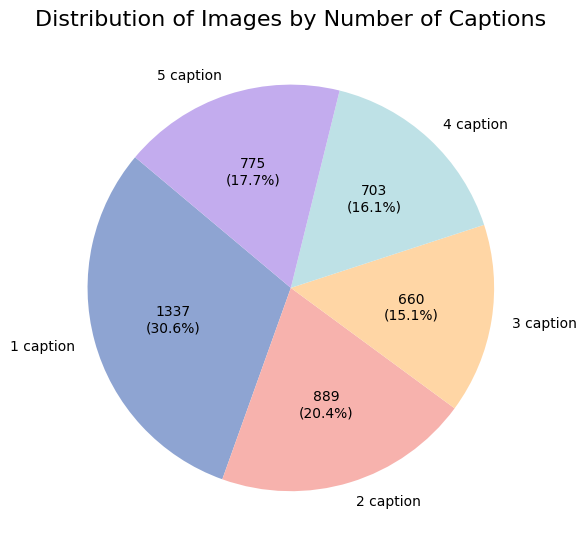

In [44]:
caption_counts_categorized, total_images = analyze_caption_counts(flickr30k)
plot_pie_chart(caption_counts_categorized, total_images)

In [47]:
def analyze_class_distribution(df):
    """
    Analyze the class distribution of the DataFrame.

    Args:
        df (DataFrame): Input DataFrame containing the data.

    Returns:
        Series: Class distribution.
        int: Total number of images.
    """
    class_distribution = df['classified_label'].value_counts()
    total_images = class_distribution.sum()
    return class_distribution, total_images

def plot_class_distribution(class_distribution, total_images):
    """
    Plot a pie chart showing the distribution of image classes.

    Args:
        class_distribution (Series): Class distribution.
        total_images (int): Total number of images.
    """
    labels = class_distribution.index
    colors = ['#8EA4D2', '#F7B2AD', '#FFD6A5', '#BEE1E6', '#C3ACEE']

    def func(pct, allvals):
        absolute = int(pct/100.*total_images)
        return "{:d}\n({:.1f}%)".format(absolute, pct)

    plt.figure(figsize=(6, 6))
    plt.pie(class_distribution, labels=labels, colors=colors, startangle=140,
            autopct=lambda pct: func(pct, class_distribution))
    plt.title('Distribution of Image Classes', fontsize=16)
    plt.tight_layout() 
    plt.show()

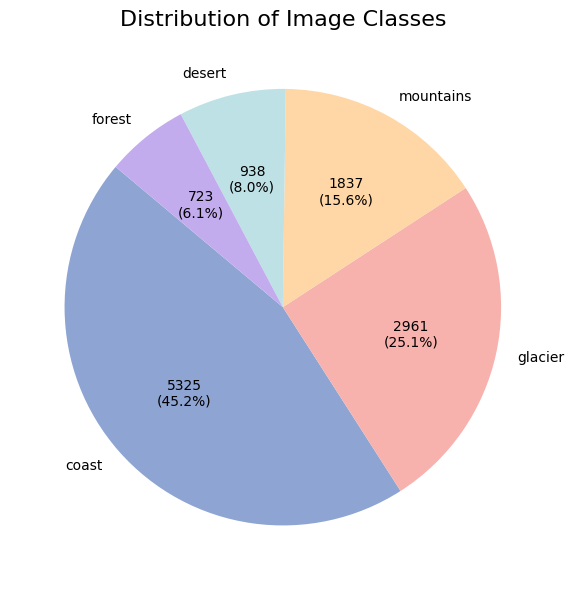

In [48]:
class_distribution, total_images = analyze_class_distribution(flickr30k)
plot_class_distribution(class_distribution, total_images)

##### Analysis Across All Dataset
- Unique Word 
- Most Frequent Word 
- Caption Lengths
- Caption Repetition
- Caption Accuracy
- Clustering

In [14]:
file_path = {'BLIP-2': blip, 
            'Kosmos-2': kosmos, 
            'Flickr30k': flickr30k}

In [39]:
def clean_and_split(text):
    """
    Clean and split the text into individual words, removing punctuation and stopwords.
    Args:
        text (str): Input text to be cleaned and split.
    Returns:
        list: List of cleaned and split words.
    """
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    return [word.lower() for word in text.split() if word.lower() not in stop_words]

def analyze_dataset(df, dataset_label):
    """
    Analyze the dataset.
    Args:
        df (DataFrame): Input DataFrame containing the dataset.
        dataset_label (str): Label for the dataset.
    Returns:
        tuple: A tuple containing two Counters, one for all words and one for cleaned words.
    """
    caption_col = df.columns[df.columns.str.contains('caption', case=False)][0]
    all_words = df[caption_col].str.cat(sep=' ').lower().split()
    all_words_clean = clean_and_split(df[caption_col].str.cat(sep=' '))

    unique_words = set(all_words)
    unique_words_clean = set(all_words_clean)

    print(f"Unique words of {dataset_label}: {len(unique_words)}")
    print(f"Unique words w/o stopwords of {dataset_label}: {len(unique_words_clean)}")

    return Counter(all_words), Counter(all_words_clean)

def analyze_selected_datasets(dataset_files, report_label, num_datasets=None):
    """
    Analyze selected datasets based on the number of datasets specified.
    Args:
        dataset_files (dict): Dictionary containing DataFrames, where keys are dataset labels and values are DataFrames.
        report_label (str): Label for the report.
        num_datasets (int): Number of datasets to analyze. If None, analyze all.
    Returns:
        tuple: A tuple containing two Counters, one for all words and one for cleaned words across selected datasets.
    """
    selected_files = dict(list(dataset_files.items())[:num_datasets]) if num_datasets is not None else dataset_files

    all_counter = Counter()
    clean_counter = Counter()

    for label, df in selected_files.items():
        print(f"\nAnalyzing dataset: {label}")
        counter, clean = analyze_dataset(df, label)
        all_counter += counter
        clean_counter += clean

    print(f"\n{report_label}:")
    print(f"Total unique words: {len(all_counter)}")
    print(f"Total unique words w/o stopwords: {len(clean_counter)}")

    return all_counter, clean_counter

def plot_top_words(counter, title):
    """
    Plot the top words from the given counter.
    Args:
        counter (Counter): Counter object containing word frequencies.
        title (str): Title for the plot.
    """
    top_words = counter.most_common(10)
    words, counts = zip(*top_words)
    custom_color = (0.1, 0.4, 0.8)
    plt.figure(figsize=(5, 3))
    plt.barh(words, counts, color=custom_color, height=0.7)
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def word_cloud(counter, title):
    """
    Generate and display a word cloud from the given counter.

    Args:
        counter (Counter): Counter object containing word frequencies.
        title (str): Title for the word cloud.
    """
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(counter)
    plt.figure(figsize=(6, 3), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=24)
    plt.show()

Unique words of BLIP-2: 2450
Unique words w/o stopwords of BLIP-2: 2148


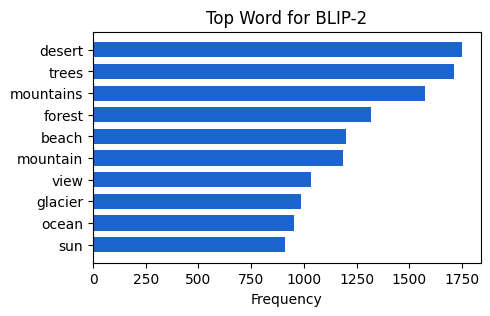

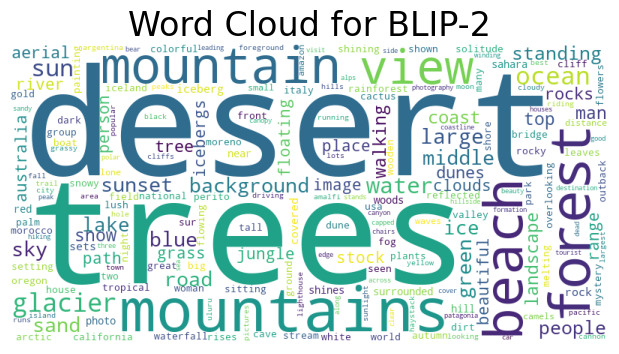

Unique words of Kosmos-2: 3207
Unique words w/o stopwords of Kosmos-2: 2626


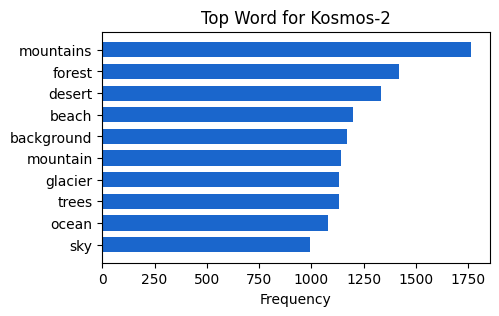

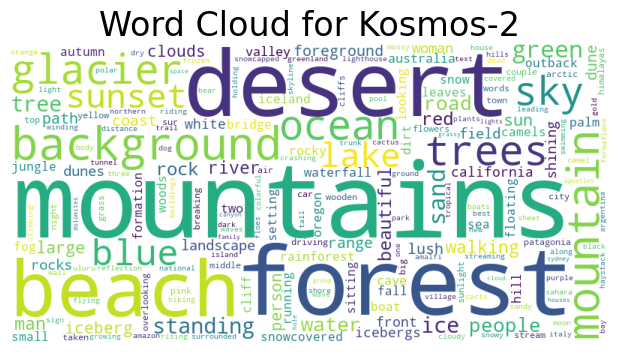

Unique words of Flickr30k: 4722
Unique words w/o stopwords of Flickr30k: 4590


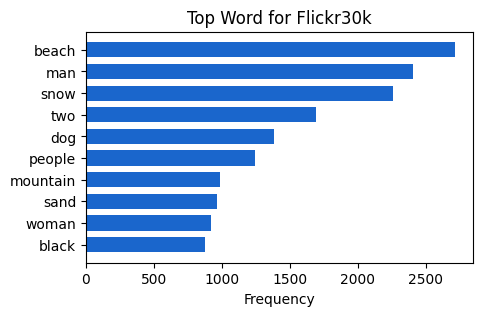

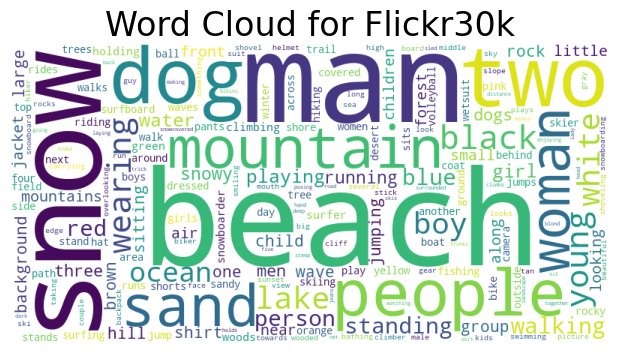

In [40]:
for label, df in file_path.items():
    _, clean_counter = analyze_dataset(df, label)
    plot_top_words(clean_counter, f"Top Word for {label}")
    word_cloud(clean_counter, f"Word Cloud for {label}")


Analyzing dataset: BLIP-2
Unique words of BLIP-2: 2450
Unique words w/o stopwords of BLIP-2: 2148

Analyzing dataset: Kosmos-2
Unique words of Kosmos-2: 3207
Unique words w/o stopwords of Kosmos-2: 2626

For Landscape Dataset:
Total unique words: 4133
Total unique words w/o stopwords: 3341


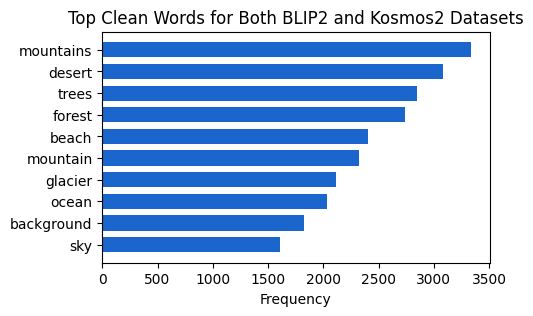

In [41]:
all_counter_first_two, clean_counter_first_two = analyze_selected_datasets(file_path, "For Landscape Dataset", num_datasets=2)
plot_top_words(clean_counter_first_two, "Top Clean Words for Both BLIP2 and Kosmos2 Datasets")


Analyzing dataset: BLIP-2
Unique words of BLIP-2: 2450
Unique words w/o stopwords of BLIP-2: 2148

Analyzing dataset: Kosmos-2
Unique words of Kosmos-2: 3207
Unique words w/o stopwords of Kosmos-2: 2626

Analyzing dataset: Flickr30k
Unique words of Flickr30k: 4722
Unique words w/o stopwords of Flickr30k: 4590

For All Datasets:
Total unique words: 7304
Total unique words w/o stopwords: 6428


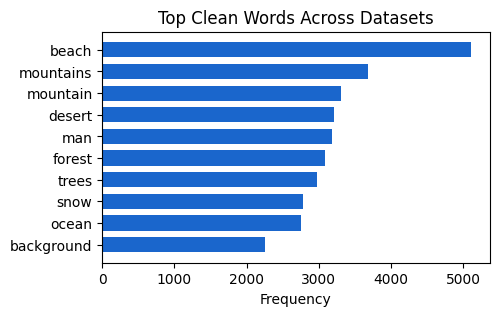

In [42]:
all_counter_all, clean_counter_all = analyze_selected_datasets(file_path, "For All Datasets")
plot_top_words(clean_counter_all, "Top Clean Words Across Datasets")

In [88]:
def analyze_caption_lengths(df, title):
    """
    Analyze caption lengths within the provided DataFrame.

    Args:
        df (DataFrame): The DataFrame to analyze.
        title (str): The label of the dataset for display purposes.
    """
    if 'image_caption' in df.columns:
        caption_col = 'image_caption'
    elif 'caption' in df.columns:
        caption_col = 'caption'
    else:
        print(f"No known caption column found in {title}.")
        return

    caption_lengths = df[caption_col].apply(lambda x: len(x.split()))
    mean_length = round(caption_lengths.mean(), 2)
    min_length = caption_lengths.min()
    max_length = caption_lengths.max()

    print(f"Mean caption length for {title}: {mean_length}")
    print(f"Minimum caption length for {title}: {min_length}")
    print(f"Maximum caption length for {title}: {max_length}")

    unique_captions = df[caption_col].nunique()
    print(f"Number of unique captions for {title}: {unique_captions}\n")

def analyze_caption_lengths_by_class(df, title):
    """
    Analyze caption lengths by class within the provided DataFrame.

    Args:
        df (DataFrame): The DataFrame to analyze.
        title (str): The label of the dataset for display purposes.
    """
    if 'image_class' in df.columns:
        class_col = 'image_class'
    elif 'classified_label' in df.columns:
        class_col = 'classified_label'
    else:
        print(f"No known class column found in {title}.")
        return

    caption_col = 'image_caption' if 'image_caption' in df.columns else 'caption'

    for image_class, group in df.groupby(class_col):
        caption_lengths = group[caption_col].apply(lambda x: len(x.split()))
        mean_length = round(caption_lengths.mean(), 2)
        min_length = caption_lengths.min()
        max_length = caption_lengths.max()

        print(f"CLASS: {image_class} in {title}")
        print(f"Mean caption length: {mean_length}")
        print(f"Minimum caption length: {min_length}")
        print(f"Maximum caption length: {max_length}")

        unique_captions = group[caption_col].nunique()
        print(f"Number of unique captions: {unique_captions}")
        print("---")

In [89]:
for label, df in file_path.items():
    analyze_caption_lengths(df, label)

Mean caption length for BLIP-2: 8.5
Minimum caption length for BLIP-2: 2
Maximum caption length for BLIP-2: 20
Number of unique captions for BLIP-2: 8710

Mean caption length for Kosmos-2: 7.52
Minimum caption length for Kosmos-2: 1
Maximum caption length for Kosmos-2: 40
Number of unique captions for Kosmos-2: 7759

Mean caption length for Flickr30k: 12.63
Minimum caption length for Flickr30k: 2
Maximum caption length for Flickr30k: 73
Number of unique captions for Flickr30k: 11701



In [90]:
for label, df in file_path.items():
    analyze_caption_lengths_by_class(df, label)

CLASS: Coast in BLIP-2
Mean caption length: 8.21
Minimum caption length: 2
Maximum caption length: 20
Number of unique captions: 1837
---
CLASS: Desert in BLIP-2
Mean caption length: 8.26
Minimum caption length: 3
Maximum caption length: 20
Number of unique captions: 1666
---
CLASS: Forest in BLIP-2
Mean caption length: 8.58
Minimum caption length: 3
Maximum caption length: 20
Number of unique captions: 1758
---
CLASS: Glacier in BLIP-2
Mean caption length: 8.78
Minimum caption length: 3
Maximum caption length: 20
Number of unique captions: 1673
---
CLASS: Mountain in BLIP-2
Mean caption length: 8.69
Minimum caption length: 2
Maximum caption length: 20
Number of unique captions: 1933
---
CLASS: Coast in Kosmos-2
Mean caption length: 8.49
Minimum caption length: 2
Maximum caption length: 28
Number of unique captions: 1876
---
CLASS: Desert in Kosmos-2
Mean caption length: 7.72
Minimum caption length: 1
Maximum caption length: 30
Number of unique captions: 1553
---
CLASS: Forest in Kosmo

In [93]:
def find_repeated_captions(df, title):
    """
    Finds and reports repeated captions within the provided DataFrame.

    Args:
        df (DataFrame): The DataFrame to search for repeated captions.
        title (str): The label of the dataset for display purposes.
    """
    if 'image_caption' in df.columns:
        caption_col = 'image_caption'
    elif 'caption' in df.columns:
        caption_col = 'caption'
    else:
        print(f"No known caption column found in {title}.")
        return
    
    # Identifying all duplicated captions
    duplicated_df = df[df.duplicated(caption_col, keep=False)]
    # Count occurrences of each caption and sort them in descending order
    caption_counts = duplicated_df[caption_col].value_counts().sort_values(ascending=False)

    print(f"Dataset: {title}")
    total_repeated = caption_counts.size
    print(f"Total number of unique captions repeated: {total_repeated}\n")

    for caption, count in caption_counts.items():
        print(f'Caption "{caption}" repeated {count} times')
    print("")

In [95]:
for label, df in file_path.items():
    find_repeated_captions(df, label)

Dataset: BLIP-2
Total number of unique captions repeated: 1315

Caption "the sahara desert in morocco" repeated 75 times
Caption "the sun shines through the trees in a forest" repeated 54 times
Caption "the perito moreno glacier in argentina" repeated 42 times
Caption "sand dunes in the desert" repeated 38 times
Caption "the sun rises over the desert" repeated 32 times
Caption "haystack rock, cannon beach, oregon" repeated 30 times
Caption "sunlight shining through the trees in a forest" repeated 29 times
Caption "a lake surrounded by mountains and trees" repeated 28 times
Caption "the perito moreno glacier in patagonia" repeated 26 times
Caption "icebergs floating in the water with mountains in the background" repeated 25 times
Caption "the desert is a place of mystery and mystery is a place of mystery" repeated 24 times
Caption "the desert is a place of solitude and solitude is a place of solitude" repeated 24 times
Caption "the sun sets over the desert" repeated 22 times
Caption "ic

In [83]:
def analyze_caption_accuracy(df, file_label):
    """
    Analyze captions within the provided DataFrame for repetitions and plot the results.

    Args:
        df (DataFrame): The DataFrame to analyze.
        file_label (str): The label of the dataset for display purposes.
    """
    caption_col = df.columns[df.columns.str.contains('caption', case=False)][0]

    def has_repetition(caption):
        words = caption.split()
        seen = set()
        for i in range(len(words) - 1):
            phrase = ' '.join(words[i:i+2])
            if phrase in seen:
                return True
            seen.add(phrase)
        return False

    df['is_inaccurate'] = df[caption_col].apply(has_repetition)

    accurate_count = (df['is_inaccurate'] == False).sum()
    inaccurate_count = (df['is_inaccurate'] == True).sum()

    sizes = [accurate_count, inaccurate_count]
    labels = ['Accurate', 'Inaccurate']
    colors = ['#FF8C00', '#4682B4'] 
    total = sum(sizes)
    percentages = [f'{100 * (size / total):.2f}%' for size in sizes]
    labels_with_counts = [f'{label}: {count},\n{percentage}' for label, count, percentage in zip(labels, sizes, percentages)]

    fig, ax = plt.subplots()
    textprops = {'fontsize': 9, 'weight': 'bold'}
    wedges, texts = ax.pie(sizes, labels=labels_with_counts, colors=colors, startangle=90, counterclock=False, textprops=textprops)
    plt.legend(wedges, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)
    plt.title(f'Caption Accuracy in {file_label}', pad=25, fontsize=14)
    plt.axis('equal')
    plt.show()

    return accurate_count, inaccurate_count

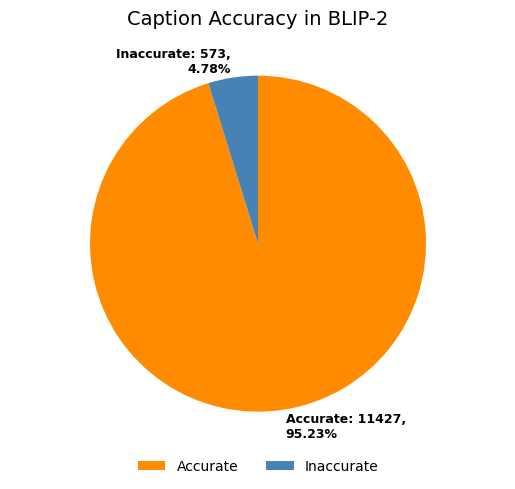

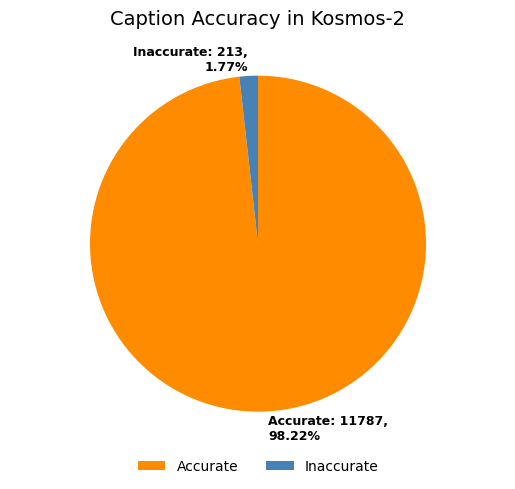

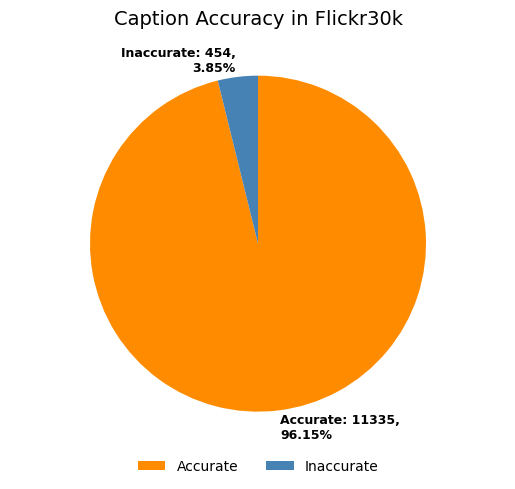

In [85]:
for label, df in file_path.items():
    analyze_caption_accuracy(df, label)

#### Tokenizing sentences & Dimensionality Reduction
By default, use `all-mpnet-base-v2` model to embed all our captions into embeddings

In [17]:
def embed_captions(all_captions:list, device:str='cuda', embedding_model=None):  
    """
    Tokenise list of captions based on the embedding model of choice

    Args:
        all_captions (list): List of captions
        device (str, optional): cpu or cuda, defaults to cuda
        embedding_model (optional): embedding model of choice, defaults to None.
                                    if embedding_model is None, default of all-mpnet-base-v2 will be used

    Returns:
        embeddings: tokenized captions
    """
    if embedding_model == None:
        embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

    #tokenizing captions
    embeddings = embedding_model.encode(all_captions, device=device)
    
    return embeddings


def umap_reduction(sentence_embeddings, n_neighbours:int=100, n_components:int=3, metrics:str='cosine'):
    """
    Reduce dimensionality of sentence embeddings with UMAP
    Please refer to UMAP documents for more details: https://umap-learn.readthedocs.io/en/latest/parameters.html

    Args:
        sentence_embeddings: sentence embeddings
        n_neighbours (int, optional): Balances local vs global structure, the larger the value, the more global the mapping. Defaults to 100.
        n_components (int, optional): Dimension the data will be reduced to. Defaults to 3.
        metrics (str, optional): Distance metrics  used for clustering. Defaults to 'cosine'.

        
    Returns:
        umap_embeddings: reduced sentence embeddings
    """
    umap_embeddings = (umap.UMAP(n_neighbors= n_neighbours,
                              n_components= n_components,
                              metric= metrics)
                              .fit_transform(sentence_embeddings))
    
    return umap_embeddings


In [ ]:
blip_umap_embeddings = umap_reduction(embed_captions(blip['image_caption'].to_list()))
kosmos_umap_embeddings = umap_reduction(embed_captions(kosmos['image_caption'].to_list()))

#### Clustering

In [63]:
def plot_graph(embeddings, num_clusters:int, cluster_labels:list, title:str):
    """
    Function to plot cluster graph

    Args:
        embeddings: umap embeddings
        num_cluster (int): total number of clusters, used to determine colour map
        cluster_labels (list): list of corresponding cluster values for each respective embeddings
        title (str): title of graph
    """
    try:
        #creating colours
        colors = plt.colormaps.get_cmap('gist_rainbow')
        cmap = ListedColormap(colors(np.linspace(0, 1, num_clusters)))
        
        #plot graph
        plt.figure(figsize=(8, 8))  
        cluster_graph = plt.scatter(embeddings[:, 0], embeddings[:, 1], #using the first 2 dimensions of embeddings
                            c=cluster_labels, s=1, cmap=cmap)
        
        #creating legends
        legend = [f'Cluster {i}' for i in range(num_clusters)]
        plt.legend(handles=cluster_graph.legend_elements()[0], labels=legend)
        plt.title(title)
        plt.show()
        
    except Exception as e:
        print(f"Unable to plot graph, {e}")

In [64]:
#K-means clustering
def Kmeans_clustering(all_captions:list, embeddings, num_cluster:int, csv_filepath:str=None, show_plot:bool=True, plot_title:str=None):
    """
    Run Kmeans clustering on dataset

    Args:
        all_captions (list): list of captions in str
        embeddings: UMAP / sentence embeddings of all captions
        num_cluster (int): number of clusters 
        csv_filepath (str, optional): filepath to save the csv of captions and their cluster labels, defaults to None.
        show_plot (bool, optional): boolean to determine if the cluster graph should be shown, defaults to True.
        plot_title (str, optional): title of graph, defaults to None
    
    Returns:
        sorted_combined_sentence_labels: list of caption (str) and their label
    """
    #cluster the data
    clusters = KMeans(n_clusters=num_cluster, random_state=0, n_init="auto").fit(embeddings)
    
    #retrieve labels for each caption 
    cluster_labels = clusters.labels_ #list of labels for each caption

    #merge the labels to the caption and sort it by labels
    combined_sentence_labels = list(zip(all_captions, cluster_labels))
    sorted_combined_sentence_labels = sorted(combined_sentence_labels, key=lambda x: x[1])

    #save to csv if filepath is given
    if csv_filepath != None:
        caption_df = pd.DataFrame(sorted_combined_sentence_labels, columns=['Caption', 'Cluster Label'])
        caption_df.to_csv(csv_filepath, index=False)
        print(f"Saved results to {csv_filepath}")

    #plot graph if show_plot is true
    if show_plot:
        plot_graph(embeddings, num_cluster, cluster_labels, plot_title)

    return sorted_combined_sentence_labels

In [65]:
#HDBScan clustering
def HDBScan_clustering(all_captions:list, 
                       embeddings, 
                       metric:str='euclidean',
                       cluster_selection_method = 'eom',
                       min_cluster_size:int=15,
                       min_samples:int=None, 
                       csv_filepath:str=None, 
                       show_plot:bool=True,
                       plot_title:str=None):
    """
    Run HDBScan clustering on dataset
    Please refer to HDBScan documents for more details: https://hdbscan.readthedocs.io/en/latest/parameter_selection.html 

    Args:
        all_captions (list): list of captions in str
        embeddings: UMAP / sentence embeddings of all captions
        metric (str, optional): metrics used for clustering, defaults to elucidean
        min_cluster_size (int, optional): minimum of captions per cluster, defaults to None
        min_samples (int, optional): determines how conservative samples will be
        csv_filepath (str, optional): filepath to save the csv of captions and their cluster labels. Defaults to None.
        show_plot (bool, optional): boolean to determine if the cluster graph should be shown. Defaults to True.
        plot_title (str, optional): title of graph, defaults to None

    Returns:
        sorted_combined_sentence_labels: list of caption (str) and their label
    """    

    #cluster the data
    clusters = hdbscan.HDBSCAN(metric=metric,
            cluster_selection_method=cluster_selection_method,
            min_cluster_size=min_cluster_size,
            min_samples=min_samples).fit(embeddings)
    
    #retrieve labels for each caption 
    cluster_labels = clusters.labels_ #list of labels for each caption

    #merge the labels to the caption and sort it by labels
    combined_sentence_labels = list(zip(all_captions, cluster_labels))
    sorted_combined_sentence_labels = sorted(combined_sentence_labels, key=lambda x: x[1])

    #save to csv if filepath is given
    if csv_filepath != None:
        caption_df = pd.DataFrame(sorted_combined_sentence_labels, columns=['Caption', 'Cluster Label'])
        caption_df.to_csv(csv_filepath, index=False)
        print(f"Saved results to {csv_filepath}")

    #plot graph if show_plot is true
    if show_plot:
        plot_graph(embeddings, len(cluster_labels), cluster_labels, plot_title)

    return sorted_combined_sentence_labels


Saved results to ../blip_kmeans.csv


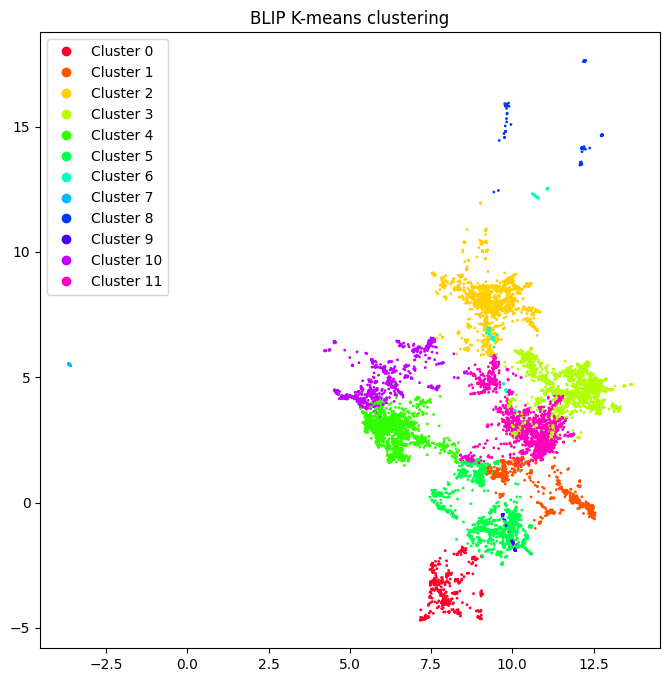

Saved results to ../blip_umap.csv


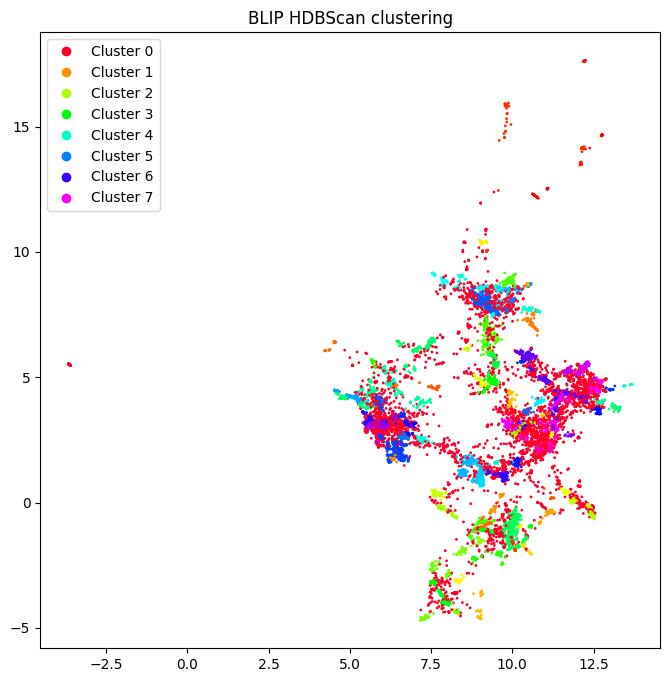

In [68]:
blip_kmeans = Kmeans_clustering(
    blip['image_caption'].to_list(),
    blip_umap_embeddings,
    12,
    '../blip_kmeans.csv',
    True,
    'BLIP K-means clustering'
)

blip_hdbscan = HDBScan_clustering(
    all_captions=blip['image_caption'],
    embeddings=blip_umap_embeddings,
    csv_filepath='../blip_umap.csv',
    show_plot=True,
    plot_title= 'BLIP HDBScan clustering'
)

Saved results to ../kosmos_kmeans.csv


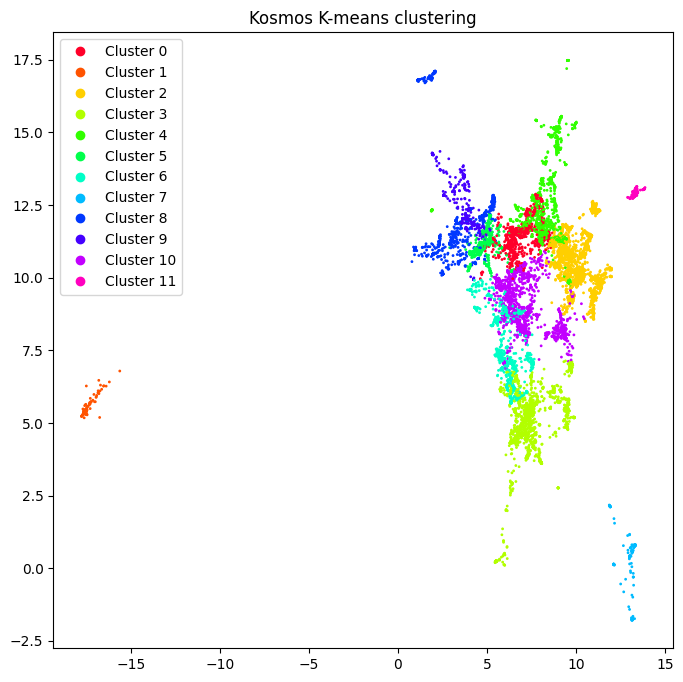

Saved results to ../kosmos_umap.csv


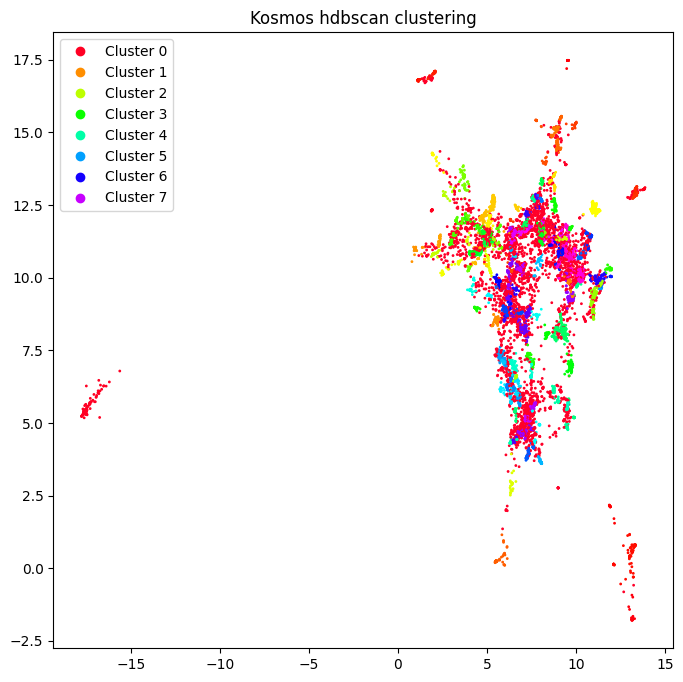

In [67]:
kosmos_kmeans = Kmeans_clustering(
    kosmos['image_caption'].to_list(),
    kosmos_umap_embeddings,
    12,
    '../kosmos_kmeans.csv',
    True,
    'Kosmos K-means clustering'
)

kosmos_hdbscan = HDBScan_clustering(
    all_captions=kosmos['image_caption'],
    embeddings=kosmos_umap_embeddings,
    csv_filepath='../kosmos_umap.csv',
    show_plot=True,
    plot_title='Kosmos HDBScan clustering'
)